## Prepare datasets

In [ ]:
#!pip install -q prophet scikit-learn pandas numpy matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.random.seed(42)

In [ ]:
# Define helper functions for Prophet training
def prepare_prophet_dataframes(train_df, test_df):
    """Prepare DataFrames for Prophet with ds, y columns and external regressors"""
    y_train_full = train_df['requests_count'].values
    y_test = test_df['requests_count'].values

    # Time-based split
    split_idx = int(len(y_train_full) * 0.8)
    y_train = y_train_full[:split_idx]
    y_valid = y_train_full[split_idx:]

    # Prepare train dataframe with regressors
    df_train = pd.DataFrame({
        'ds': train_df['timestamp'][:split_idx],
        'y': y_train,
        'hour_of_day': train_df['hour_of_day'][:split_idx],
        'day_of_week': train_df['day_of_week'][:split_idx],
        'rolling_mean_1h': train_df['rolling_mean_1h'][:split_idx].fillna(0),
        'rolling_std_1h': train_df['rolling_std_1h'][:split_idx].fillna(0),
        'rolling_mean_5m': train_df['rolling_mean_5m'][:split_idx].fillna(0),
        'rolling_std_5m': train_df['rolling_std_5m'][:split_idx].fillna(0),
        'lag_requests_1h': train_df['lag_requests_1h'][:split_idx].fillna(0),
        'is_burst': train_df['is_burst'][:split_idx].fillna(0),
        'burst_ratio': train_df['burst_ratio'][:split_idx].fillna(0)
    })

    # Prepare validation dataframe with regressors
    df_valid = pd.DataFrame({
        'ds': train_df['timestamp'][split_idx:],
        'y': y_valid,
        'hour_of_day': train_df['hour_of_day'][split_idx:],
        'day_of_week': train_df['day_of_week'][split_idx:],
        'rolling_mean_1h': train_df['rolling_mean_1h'][split_idx:].fillna(0),
        'rolling_std_1h': train_df['rolling_std_1h'][split_idx:].fillna(0),
        'rolling_mean_5m': train_df['rolling_mean_5m'][split_idx:].fillna(0),
        'rolling_std_5m': train_df['rolling_std_5m'][split_idx:].fillna(0),
        'lag_requests_1h': train_df['lag_requests_1h'][split_idx:].fillna(0),
        'is_burst': train_df['is_burst'][split_idx:].fillna(0),
        'burst_ratio': train_df['burst_ratio'][split_idx:].fillna(0)
    })

    # Prepare test dataframe with regressors
    df_test = pd.DataFrame({
        'ds': test_df['timestamp'],
        'y': y_test,
        'hour_of_day': test_df['hour_of_day'],
        'day_of_week': test_df['day_of_week'],
        'rolling_mean_1h': test_df['rolling_mean_1h'].fillna(0),
        'rolling_std_1h': test_df['rolling_std_1h'].fillna(0),
        'rolling_mean_5m': test_df['rolling_mean_5m'].fillna(0),
        'rolling_std_5m': test_df['rolling_std_5m'].fillna(0),
        'lag_requests_1h': test_df['lag_requests_1h'].fillna(0),
        'is_burst': test_df['is_burst'].fillna(0),
        'burst_ratio': test_df['burst_ratio'].fillna(0)
    })

    return df_train, df_valid, df_test, y_train, y_valid, y_test


def train_prophet_model(df_train):
    """Train Prophet model on training data with external regressors"""
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False,
        interval_width=0.95,
        changepoint_prior_scale=0.3
    )

    # Add external regressors
    model.add_regressor('hour_of_day')
    model.add_regressor('day_of_week')
    model.add_regressor('rolling_mean_1h')
    model.add_regressor('rolling_std_1h')
    model.add_regressor('rolling_mean_5m')
    model.add_regressor('rolling_std_5m')
    model.add_regressor('lag_requests_1h')
    model.add_regressor('is_burst')
    model.add_regressor('burst_ratio')


    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        model.fit(df_train)

    return model


def generate_prophet_predictions(model, df_train, df_valid, df_test):
    """Generate predictions for all periods (must include regressors)"""
    forecast_train = model.predict(df_train)
    forecast_valid = model.predict(df_valid)
    forecast_test = model.predict(df_test)

    return (forecast_train['yhat'].values,
            forecast_valid['yhat'].values,
            forecast_test['yhat'].values,
            forecast_train, forecast_valid, forecast_test)


def compute_metrics(y_true, y_pred, name):
    """Calculate performance metrics"""
    y_pred = np.maximum(y_pred, 0)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    with np.errstate(divide='ignore', invalid='ignore'):
        smape_arr = 2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))
        smape_arr = np.nan_to_num(smape_arr, nan=0, posinf=0, neginf=0)
        smape = np.mean(smape_arr) * 100

    residuals = y_true - y_pred

    print(f"\n{name}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"sMAPE: {smape:.2f}%")
    print(f"Residuals mean: {residuals.mean():.2f}, std: {residuals.std():.2f}")

    within_10 = ((np.abs(residuals) / (y_true + 1e-6)) <= 0.1).sum() / len(y_true) * 100
    within_20 = ((np.abs(residuals) / (y_true + 1e-6)) <= 0.2).sum() / len(y_true) * 100
    print(f"Within +/-10%: {within_10:.1f}%, Within +/-20%: {within_20:.1f}%")

    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'smape': smape, 'residuals': residuals}


# Initialize results storage
timeframes = ['1m', '5m', '15m']
results_all = {}

## Process 1m timeframe

In [ ]:
print(f"\n{'='*60}")
print(f"Processing 1M timeframe")
print(f"{'='*60}\n")

TRAIN_PATH = "processed_for_modeling_v2/train_1m_autoscaling.csv"
TEST_PATH = "processed_for_modeling_v2/test_1m_autoscaling.csv"

train_df_1m = pd.read_csv(TRAIN_PATH, parse_dates=["timestamp"])
test_df_1m = pd.read_csv(TEST_PATH, parse_dates=["timestamp"])

print(f"Train: {train_df_1m.shape[0]} rows")
print(f"Test: {test_df_1m.shape[0]} rows")

df_train_1m, df_valid_1m, df_test_1m, y_train_1m, y_valid_1m, y_test_1m = prepare_prophet_dataframes(train_df_1m, test_df_1m)
print(f"Train: {len(y_train_1m)}, Validation: {len(y_valid_1m)}, Test: {len(y_test_1m)}")


Processing 1M timeframe

Train: 75660 rows
Test: 13620 rows
Train: 60528, Validation: 15132, Test: 13620


In [ ]:
# Train Prophet model for 1m
print("Training Facebook Prophet model for 1m...")

model_1m = train_prophet_model(df_train_1m)
print("Model training completed")

# Generate predictions for 1m
print("\nGenerating predictions for 1m...")
y_train_pred_1m, y_valid_pred_1m, y_test_pred_1m, forecast_train_1m, forecast_valid_1m, forecast_test_1m = generate_prophet_predictions(model_1m, df_train_1m, df_valid_1m, df_test_1m)

# Compute metrics for 1m
train_m_1m = compute_metrics(y_train_1m, y_train_pred_1m, 'Training Metrics (1m)')
valid_m_1m = compute_metrics(y_valid_1m, y_valid_pred_1m, 'Validation Metrics (1m)')
test_m_1m = compute_metrics(y_test_1m, y_test_pred_1m, 'Test Metrics (1m)')

results_all['1m'] = {
    'train': train_m_1m,
    'valid': valid_m_1m,
    'test': test_m_1m,
    'y_train': y_train_1m,
    'y_train_pred': y_train_pred_1m,
    'y_valid': y_valid_1m,
    'y_valid_pred': y_valid_pred_1m,
    'y_test': y_test_1m,
    'y_test_pred': y_test_pred_1m,
    'model': model_1m,
    'forecast_test': forecast_test_1m
}

Training Facebook Prophet model for 1m...


16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:25 - cmdstanpy - INFO - Chain [1] done processing


Model training completed

Generating predictions for 1m...

Training Metrics (1m)
MAE: 9.9790
RMSE: 14.4689
R2: 0.8008
sMAPE: 36.86%
Residuals mean: -0.14, std: 14.47
Within +/-10%: 28.1%, Within +/-20%: 46.6%

Validation Metrics (1m)
MAE: 9.9129
RMSE: 13.0410
R2: 0.6451
sMAPE: 34.79%
Residuals mean: -0.59, std: 13.03
Within +/-10%: 19.7%, Within +/-20%: 39.0%

Test Metrics (1m)
MAE: 10.7482
RMSE: 14.1823
R2: 0.7221
sMAPE: 32.14%
Residuals mean: -0.67, std: 14.17
Within +/-10%: 22.1%, Within +/-20%: 42.2%


## Process 5m timeframe

In [ ]:
print(f"\n{'='*60}")
print(f"Processing 5M timeframe")
print(f"{'='*60}\n")

TRAIN_PATH = "processed_for_modeling_v2/train_5m_autoscaling.csv"
TEST_PATH = "processed_for_modeling_v2/test_5m_autoscaling.csv"

train_df_5m = pd.read_csv(TRAIN_PATH, parse_dates=["timestamp"])
test_df_5m = pd.read_csv(TEST_PATH, parse_dates=["timestamp"])

print(f"Train: {train_df_5m.shape[0]} rows")
print(f"Test: {test_df_5m.shape[0]} rows")

df_train_5m, df_valid_5m, df_test_5m, y_train_5m, y_valid_5m, y_test_5m = prepare_prophet_dataframes(train_df_5m, test_df_5m)
print(f"Train: {len(y_train_5m)}, Validation: {len(y_valid_5m)}, Test: {len(y_test_5m)}")


Processing 5M timeframe

Train: 15132 rows
Test: 2724 rows
Train: 12105, Validation: 3027, Test: 2724


In [ ]:
# Train Prophet model for 5m
print("Training Facebook Prophet model for 5m...")

model_5m = train_prophet_model(df_train_5m)
print("Model training completed")

# Generate predictions for 5m
print("\nGenerating predictions for 5m...")
y_train_pred_5m, y_valid_pred_5m, y_test_pred_5m, forecast_train_5m, forecast_valid_5m, forecast_test_5m = generate_prophet_predictions(model_5m, df_train_5m, df_valid_5m, df_test_5m)

# Compute metrics for 5m
train_m_5m = compute_metrics(y_train_5m, y_train_pred_5m, 'Training Metrics (5m)')
valid_m_5m = compute_metrics(y_valid_5m, y_valid_pred_5m, 'Validation Metrics (5m)')
test_m_5m = compute_metrics(y_test_5m, y_test_pred_5m, 'Test Metrics (5m)')

results_all['5m'] = {
    'train': train_m_5m,
    'valid': valid_m_5m,
    'test': test_m_5m,
    'y_train': y_train_5m,
    'y_train_pred': y_train_pred_5m,
    'y_valid': y_valid_5m,
    'y_valid_pred': y_valid_pred_5m,
    'y_test': y_test_5m,
    'y_test_pred': y_test_pred_5m,
    'model': model_5m,
    'forecast_test': forecast_test_5m
}

Training Facebook Prophet model for 5m...


16:26:40 - cmdstanpy - INFO - Chain [1] start processing
16:26:42 - cmdstanpy - INFO - Chain [1] done processing


Model training completed

Generating predictions for 5m...

Training Metrics (5m)
MAE: 35.0785
RMSE: 52.4674
R2: 0.8803
sMAPE: 27.09%
Residuals mean: -1.06, std: 52.46
Within +/-10%: 37.6%, Within +/-20%: 61.9%

Validation Metrics (5m)
MAE: 32.5986
RMSE: 44.1901
R2: 0.7898
sMAPE: 22.54%
Residuals mean: -3.91, std: 44.02
Within +/-10%: 32.1%, Within +/-20%: 56.7%

Test Metrics (5m)
MAE: 36.0532
RMSE: 48.1299
R2: 0.8438
sMAPE: 21.13%
Residuals mean: -4.93, std: 47.88
Within +/-10%: 33.3%, Within +/-20%: 59.9%


## Process 15m timeframe

In [ ]:
print(f"\n{'='*60}")
print(f"Processing 15M timeframe")
print(f"{'='*60}\n")

TRAIN_PATH = "processed_for_modeling_v2/train_15m_autoscaling.csv"
TEST_PATH = "processed_for_modeling_v2/test_15m_autoscaling.csv"

train_df_15m = pd.read_csv(TRAIN_PATH, parse_dates=["timestamp"])
test_df_15m = pd.read_csv(TEST_PATH, parse_dates=["timestamp"])

print(f"Train: {train_df_15m.shape[0]} rows")
print(f"Test: {test_df_15m.shape[0]} rows")

df_train_15m, df_valid_15m, df_test_15m, y_train_15m, y_valid_15m, y_test_15m = prepare_prophet_dataframes(train_df_15m, test_df_15m)
print(f"Train: {len(y_train_15m)}, Validation: {len(y_valid_15m)}, Test: {len(y_test_15m)}")


Processing 15M timeframe

Train: 5044 rows
Test: 908 rows
Train: 4035, Validation: 1009, Test: 908


In [ ]:
# Train Prophet model for 15m
print("Training Facebook Prophet model for 15m...")

model_15m = train_prophet_model(df_train_15m)
print("Model training completed")

# Generate predictions for 15m
print("\nGenerating predictions for 15m...")
y_train_pred_15m, y_valid_pred_15m, y_test_pred_15m, forecast_train_15m, forecast_valid_15m, forecast_test_15m = generate_prophet_predictions(model_15m, df_train_15m, df_valid_15m, df_test_15m)

# Compute metrics for 15m
train_m_15m = compute_metrics(y_train_15m, y_train_pred_15m, 'Training Metrics (15m)')
valid_m_15m = compute_metrics(y_valid_15m, y_valid_pred_15m, 'Validation Metrics (15m)')
test_m_15m = compute_metrics(y_test_15m, y_test_pred_15m, 'Test Metrics (15m)')

results_all['15m'] = {
    'train': train_m_15m,
    'valid': valid_m_15m,
    'test': test_m_15m,
    'y_train': y_train_15m,
    'y_train_pred': y_train_pred_15m,
    'y_valid': y_valid_15m,
    'y_valid_pred': y_valid_pred_15m,
    'y_test': y_test_15m,
    'y_test_pred': y_test_pred_15m,
    'model': model_15m,
    'forecast_test': forecast_test_15m
}

16:26:46 - cmdstanpy - INFO - Chain [1] start processing


Training Facebook Prophet model for 15m...


16:26:47 - cmdstanpy - INFO - Chain [1] done processing


Model training completed

Generating predictions for 15m...

Training Metrics (15m)
MAE: 96.1993
RMSE: 147.7909
R2: 0.8886
sMAPE: 26.26%
Residuals mean: -4.98, std: 147.71
Within +/-10%: 41.4%, Within +/-20%: 66.3%

Validation Metrics (15m)
MAE: 93.6376
RMSE: 117.2674
R2: 0.8160
sMAPE: 21.47%
Residuals mean: -48.14, std: 106.93
Within +/-10%: 32.1%, Within +/-20%: 57.0%

Test Metrics (15m)
MAE: 123.9156
RMSE: 159.2878
R2: 0.7959
sMAPE: 23.45%
Residuals mean: -88.63, std: 132.35
Within +/-10%: 30.7%, Within +/-20%: 50.0%


## Visualization Results

Generate visualizations for all timeframes.


Visualizing 1M...


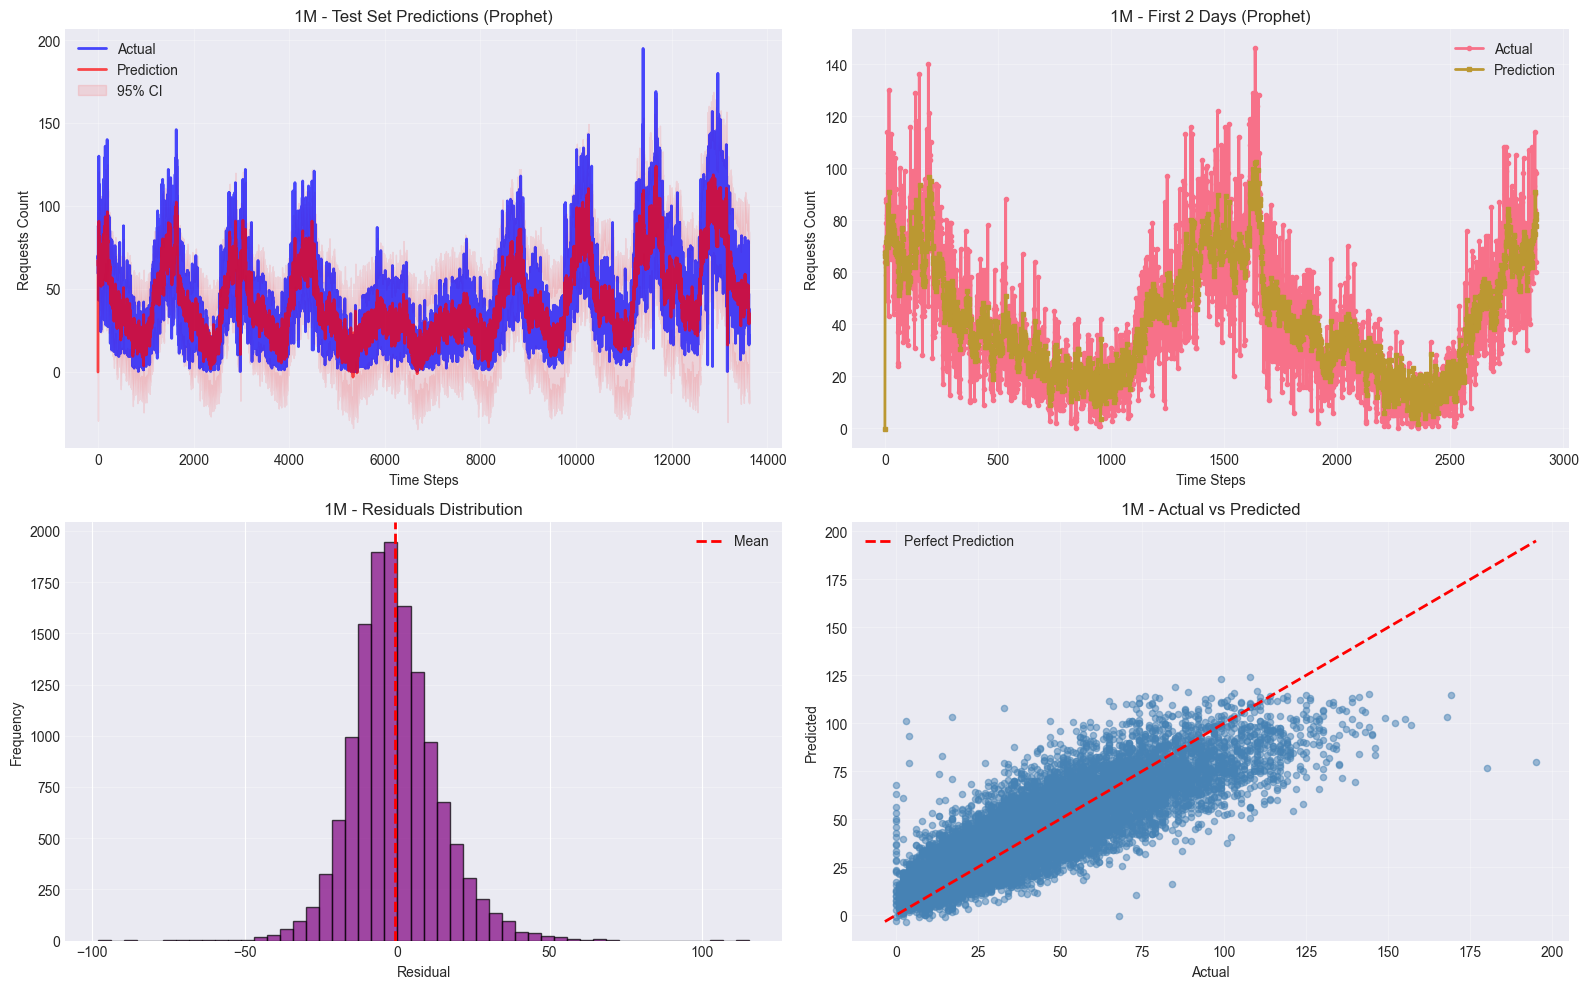

Figure saved: prophet_1m_results.png

Visualizing 5M...


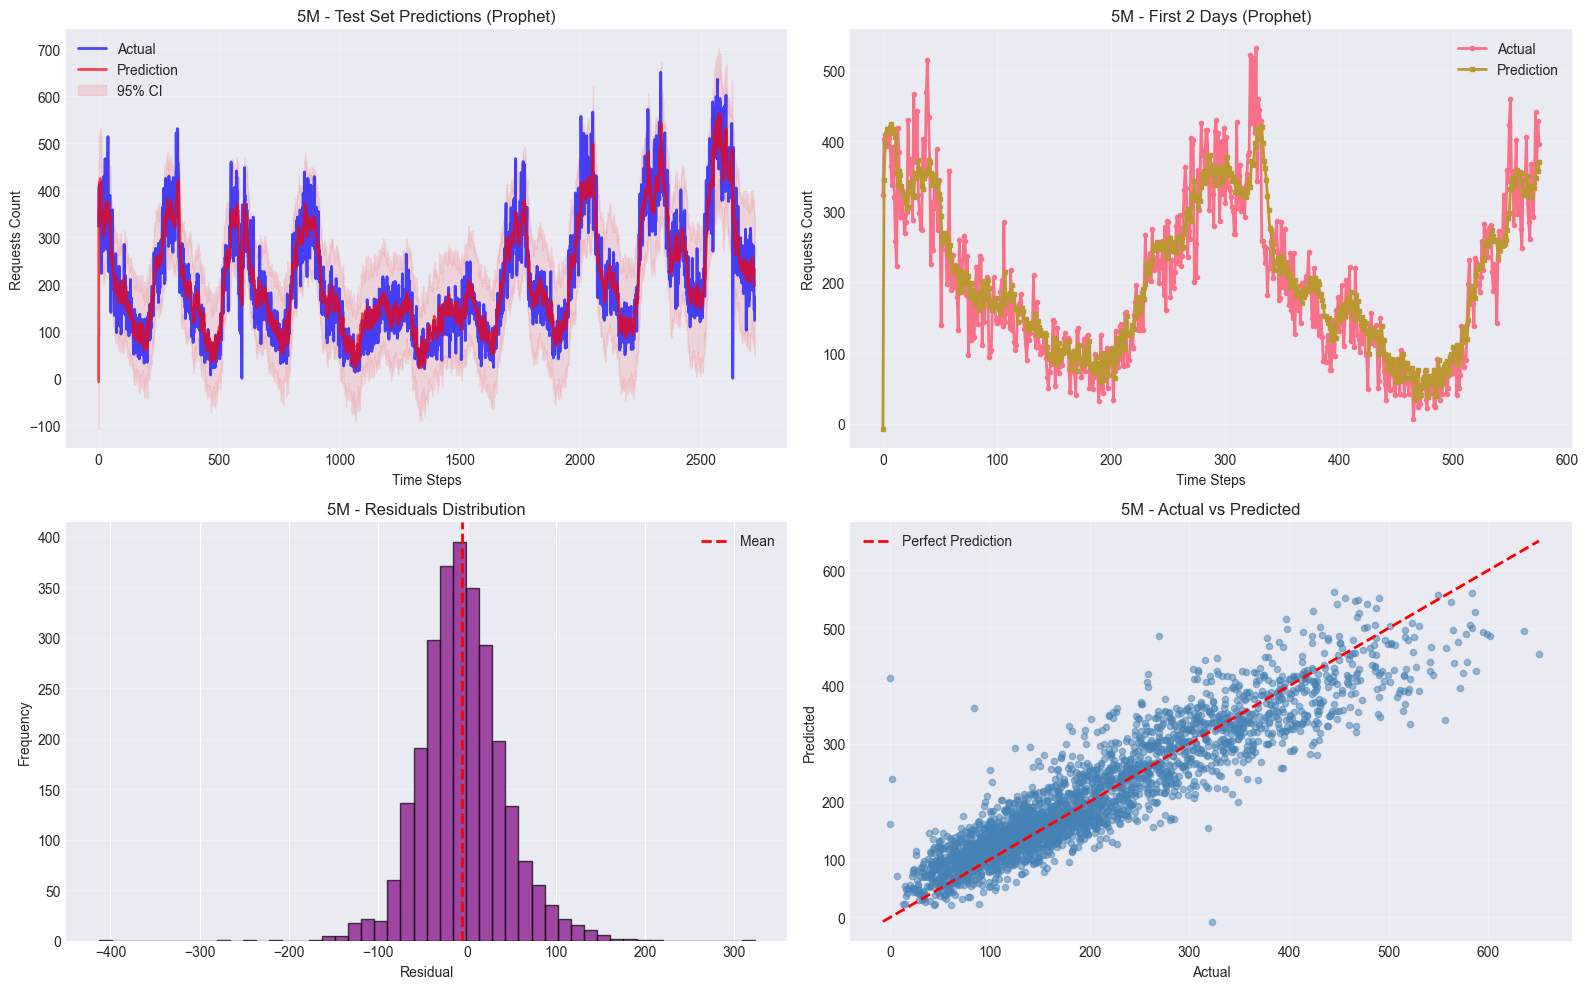

Figure saved: prophet_5m_results.png

Visualizing 15M...


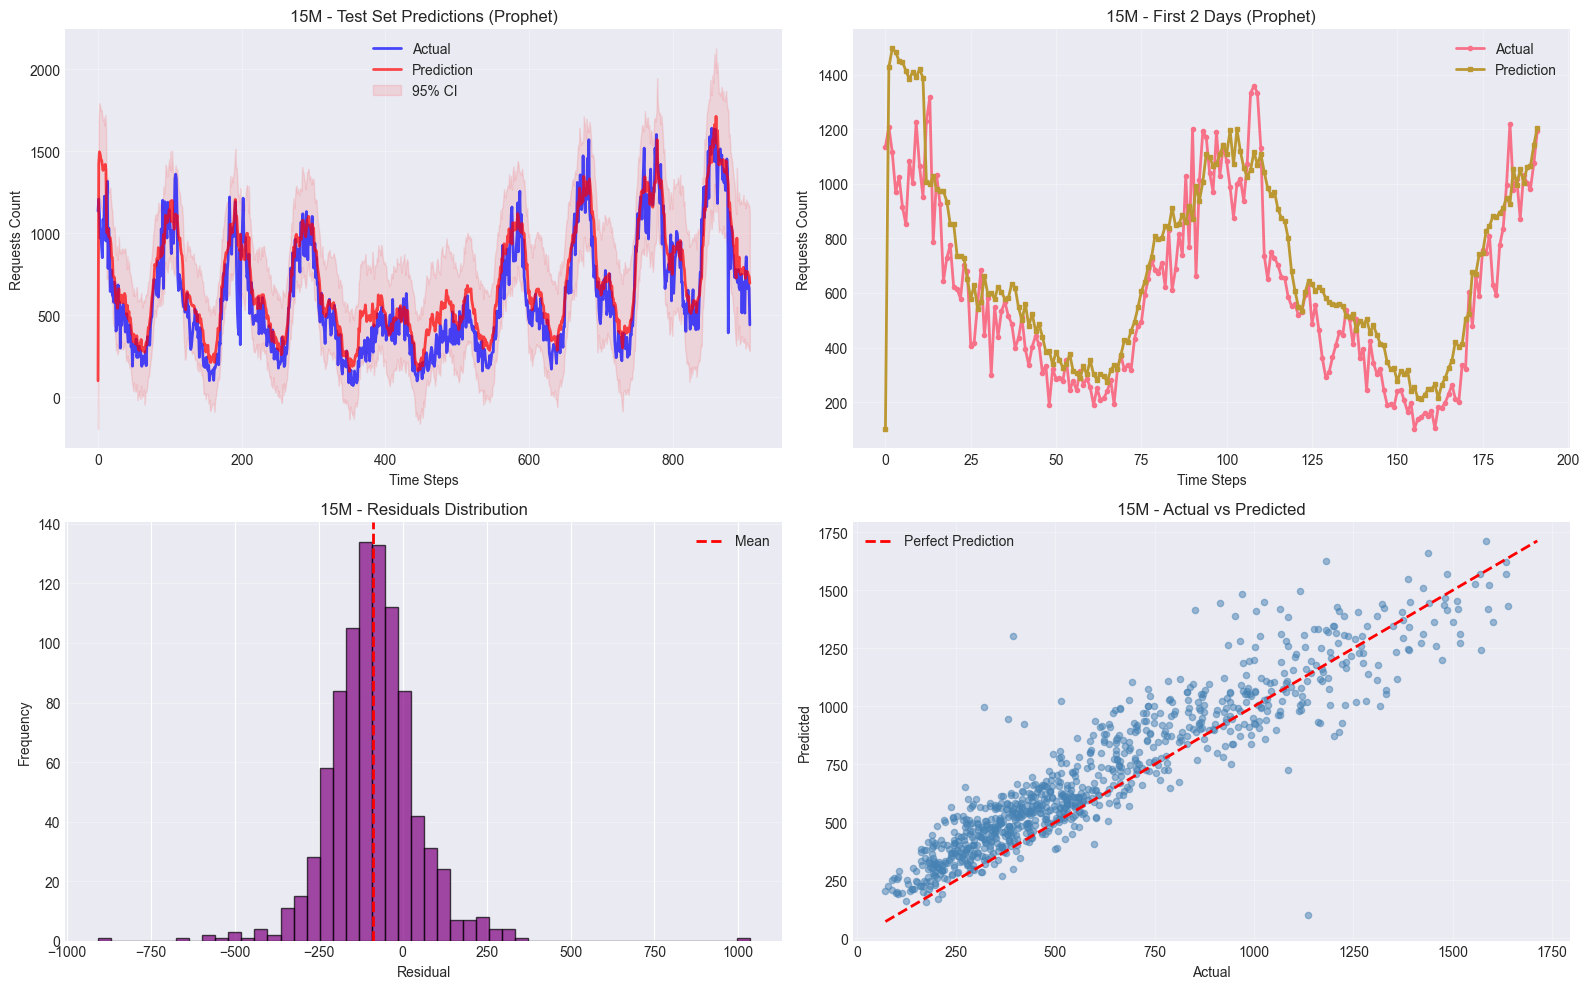

Figure saved: prophet_15m_results.png


In [ ]:
# Visualize results for 1m
def visualize_predictions(tf, y_test, y_test_pred, test_m, forecast_test):
    """Visualize predictions, residuals, and actual vs predicted"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    time_idx = np.arange(len(y_test))

    # Test predictions with confidence intervals
    ax = axes[0, 0]
    ax.plot(time_idx, y_test, label='Actual', linewidth=2, color='blue', alpha=0.7)
    ax.plot(time_idx, y_test_pred, label='Prediction', linewidth=2, color='red', alpha=0.7)
    ax.fill_between(time_idx,
                      forecast_test['yhat_lower'].values,
                      forecast_test['yhat_upper'].values,
                      color='red', alpha=0.1, label='95% CI')
    ax.set_title(f'{tf.upper()} - Test Set Predictions (Prophet)')
    ax.set_ylabel('Requests Count')
    ax.set_xlabel('Time Steps')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # First 2 days detailed
    ax = axes[0, 1]
    n = 288 if tf == '5m' else (1440 if tf == '1m' else 96)
    ax.plot(time_idx[:n*2], y_test[:n*2], 'o-', label='Actual', linewidth=2, markersize=3)
    ax.plot(time_idx[:n*2], y_test_pred[:n*2], 's-', label='Prediction', linewidth=2, markersize=3)
    ax.set_title(f'{tf.upper()} - First 2 Days (Prophet)')
    ax.set_ylabel('Requests Count')
    ax.set_xlabel('Time Steps')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Residuals distribution
    ax = axes[1, 0]
    ax.hist(test_m['residuals'], bins=50, color='purple', alpha=0.7, edgecolor='black')
    ax.axvline(test_m['residuals'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax.set_title(f'{tf.upper()} - Residuals Distribution')
    ax.set_xlabel('Residual')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Scatter: Actual vs Predicted
    ax = axes[1, 1]
    ax.scatter(y_test, y_test_pred, alpha=0.5, s=20, color='steelblue')
    min_val = min(y_test.min(), y_test_pred.min())
    max_val = max(y_test.max(), y_test_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    ax.set_title(f'{tf.upper()} - Actual vs Predicted')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'prophet_{tf}_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Figure saved: prophet_{tf}_results.png")

# Visualize all timeframes
for tf in ['1m', '5m', '15m']:
    print(f"\nVisualizing {tf.upper()}...")
    visualize_predictions(
        tf,
        results_all[tf]['y_test'],
        results_all[tf]['y_test_pred'],
        results_all[tf]['test'],
        results_all[tf]['forecast_test']
    )

## Export Predictions




In [ ]:
# Export predictions to CSV for all timeframes (train, valid, test)
def export_all_predictions(tf, df_train, df_valid, df_test,
                           y_train, y_valid, y_test,
                           y_train_pred, y_valid_pred, y_test_pred,
                           forecast_train, forecast_valid, forecast_test):
    """Export train, validation and test predictions to CSV"""

    # Train predictions
    train_results = pd.DataFrame({
        'timestamp': df_train['ds'],
        'actual': y_train,
        'predicted': y_train_pred,
        'yhat_lower': forecast_train['yhat_lower'].values,
        'yhat_upper': forecast_train['yhat_upper'].values,
        'error': y_train - y_train_pred,
        'abs_error': np.abs(y_train - y_train_pred),
        'error_pct': (np.abs(y_train - y_train_pred) / (y_train + 1e-6)) * 100,
        'split': 'train'
    })

    # Validation predictions
    valid_results = pd.DataFrame({
        'timestamp': df_valid['ds'],
        'actual': y_valid,
        'predicted': y_valid_pred,
        'yhat_lower': forecast_valid['yhat_lower'].values,
        'yhat_upper': forecast_valid['yhat_upper'].values,
        'error': y_valid - y_valid_pred,
        'abs_error': np.abs(y_valid - y_valid_pred),
        'error_pct': (np.abs(y_valid - y_valid_pred) / (y_valid + 1e-6)) * 100,
        'split': 'valid'
    })

    # Test predictions
    test_results = pd.DataFrame({
        'timestamp': df_test['ds'],
        'actual': y_test,
        'predicted': y_test_pred,
        'yhat_lower': forecast_test['yhat_lower'].values,
        'yhat_upper': forecast_test['yhat_upper'].values,
        'error': y_test - y_test_pred,
        'abs_error': np.abs(y_test - y_test_pred),
        'error_pct': (np.abs(y_test - y_test_pred) / (y_test + 1e-6)) * 100,
        'split': 'test'
    })

    # Combine all
    all_results = pd.concat([train_results, valid_results, test_results], ignore_index=True)
    all_results.to_csv(f'prophet_{tf}_all_predictions.csv', index=False)
    print(f"All predictions exported: prophet_{tf}_all_predictions.csv")

# Export for all timeframes
export_all_predictions('1m', df_train_1m, df_valid_1m, df_test_1m,
                       y_train_1m, y_valid_1m, y_test_1m,
                       y_train_pred_1m, y_valid_pred_1m, y_test_pred_1m,
                       forecast_train_1m, forecast_valid_1m, forecast_test_1m)

export_all_predictions('5m', df_train_5m, df_valid_5m, df_test_5m,
                       y_train_5m, y_valid_5m, y_test_5m,
                       y_train_pred_5m, y_valid_pred_5m, y_test_pred_5m,
                       forecast_train_5m, forecast_valid_5m, forecast_test_5m)

export_all_predictions('15m', df_train_15m, df_valid_15m, df_test_15m,
                       y_train_15m, y_valid_15m, y_test_15m,
                       y_train_pred_15m, y_valid_pred_15m, y_test_pred_15m,
                       forecast_train_15m, forecast_valid_15m, forecast_test_15m)

All predictions exported: prophet_1m_all_predictions.csv
All predictions exported: prophet_5m_all_predictions.csv
All predictions exported: prophet_15m_all_predictions.csv


In [ ]:
summary_data = []
for tf in timeframes:
    test_metrics = results_all[tf]['test']
    print(f"\n{tf.upper()}:")
    print(f"  Train MAE: {results_all[tf]['train']['mae']:.4f}")
    print(f"  Valid MAE: {results_all[tf]['valid']['mae']:.4f}")
    print(f"  Test MAE: {test_metrics['mae']:.4f}")
    print(f"  Test RMSE: {test_metrics['rmse']:.4f}")
    print(f"  Test R2: {test_metrics['r2']:.4f}")
    print(f"  Test sMAPE: {test_metrics['smape']:.2f}%")

    summary_data.append({
        'timeframe': tf,
        'train_mae': results_all[tf]['train']['mae'],
        'valid_mae': results_all[tf]['valid']['mae'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'test_smape': test_metrics['smape']
    })


1M:
  Train MAE: 9.9790
  Valid MAE: 9.9129
  Test MAE: 10.7482
  Test RMSE: 14.1823
  Test R2: 0.7221
  Test sMAPE: 32.14%

5M:
  Train MAE: 35.0785
  Valid MAE: 32.5986
  Test MAE: 36.0532
  Test RMSE: 48.1299
  Test R2: 0.8438
  Test sMAPE: 21.13%

15M:
  Train MAE: 96.1993
  Valid MAE: 93.6376
  Test MAE: 123.9156
  Test RMSE: 159.2878
  Test R2: 0.7959
  Test sMAPE: 23.45%


## Seasonality Analysis

Visualize the daily and weekly seasonality components learned by Prophet.


Seasonality Analysis: 1M


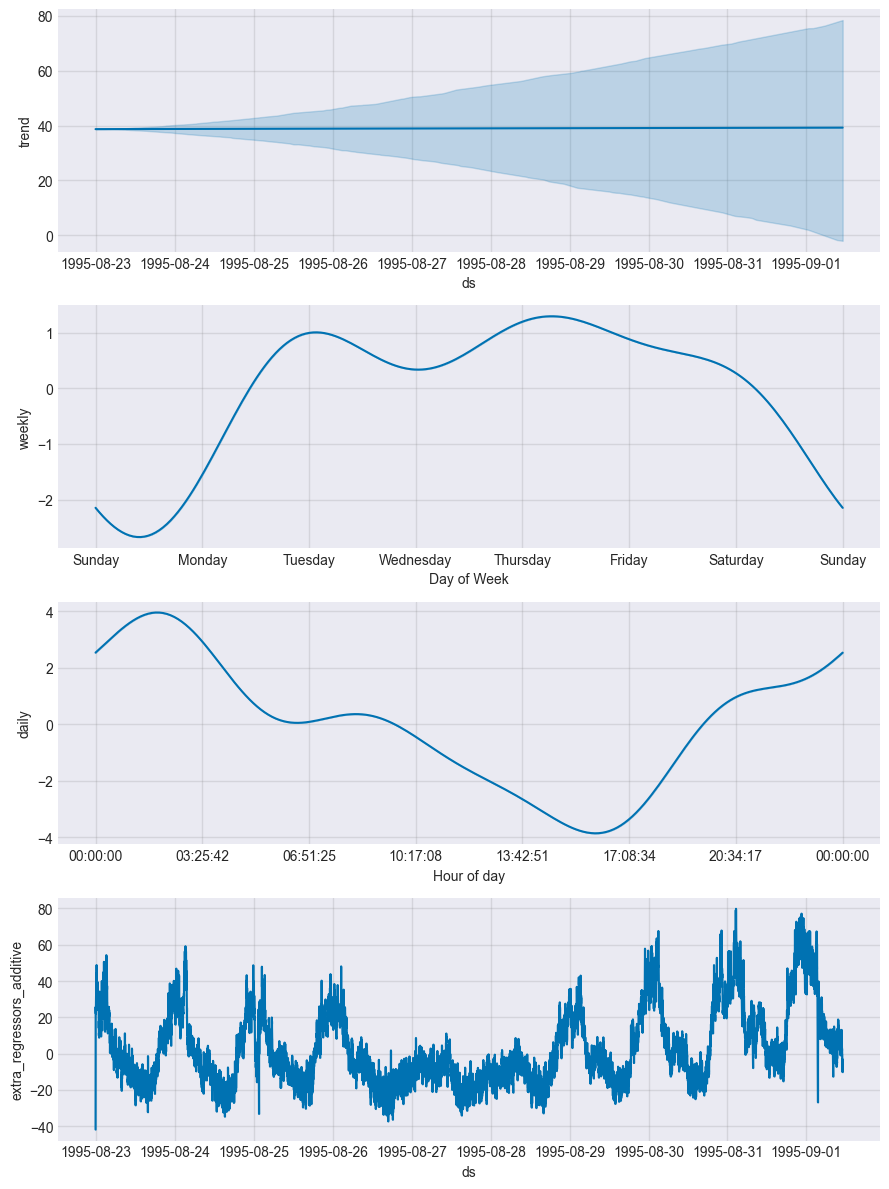

Components plot saved: prophet_1m_components.png

Seasonality Analysis: 5M


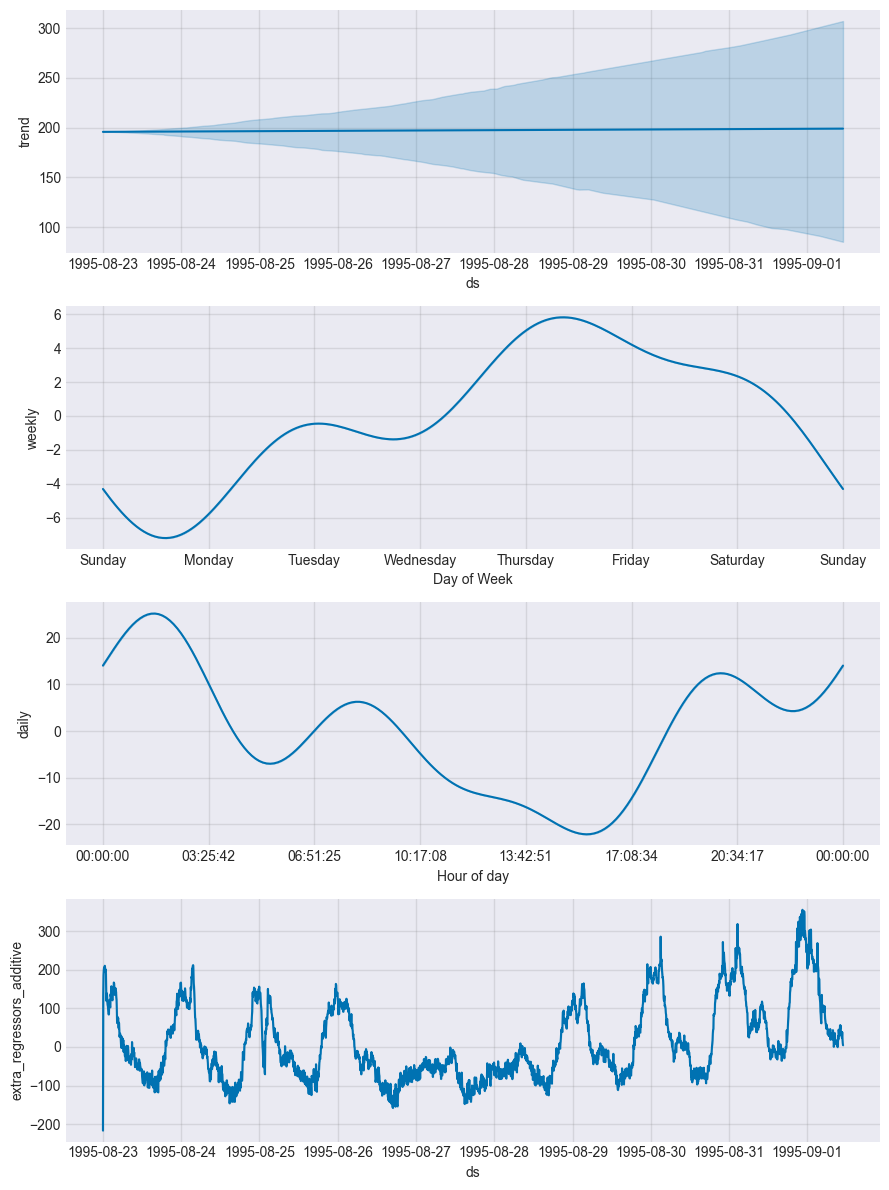

Components plot saved: prophet_5m_components.png

Seasonality Analysis: 15M


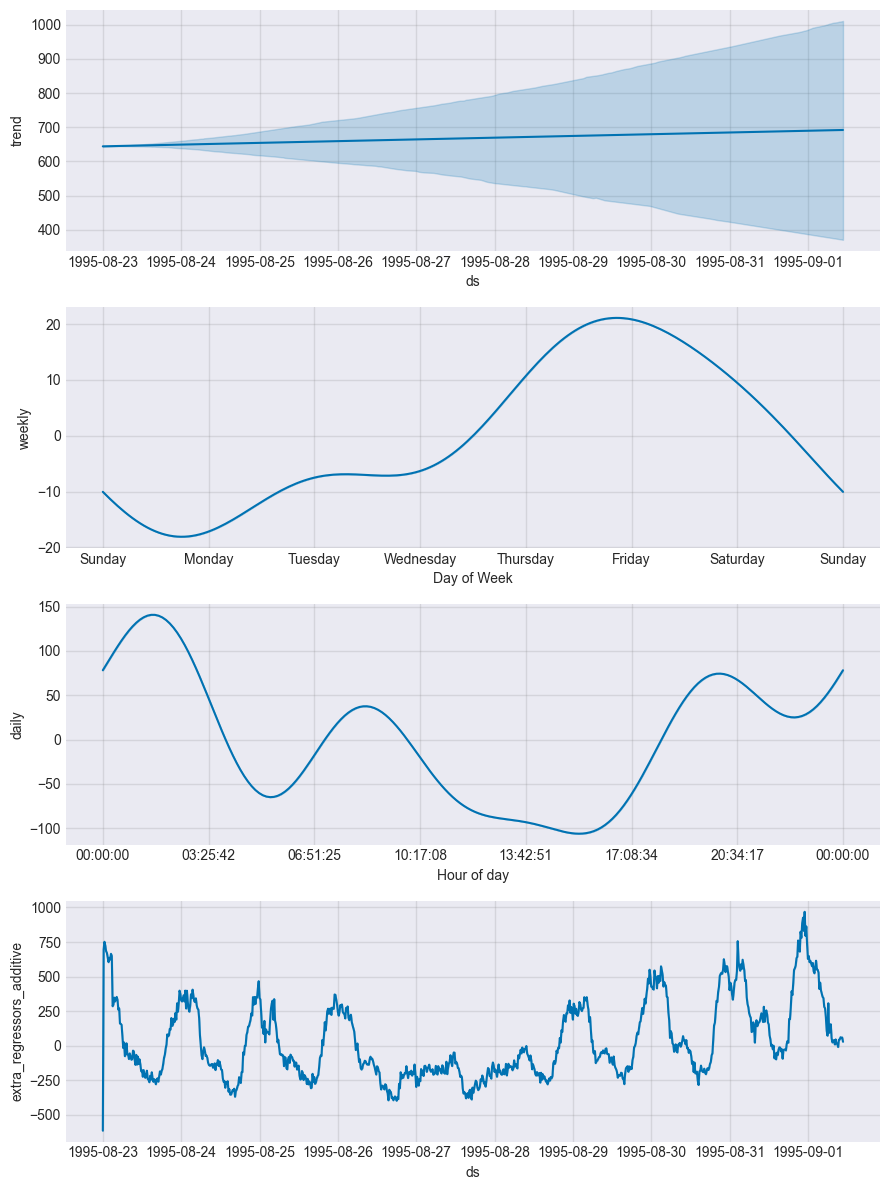

Components plot saved: prophet_15m_components.png


In [ ]:
# Analyze seasonality components for each timeframe
for tf in timeframes:
    model = results_all[tf]['model']

    print(f"\n{'='*60}")
    print(f"Seasonality Analysis: {tf.upper()}")
    print(f"{'='*60}")

    # Plot components
    fig = model.plot_components(results_all[tf]['forecast_test'])
    plt.tight_layout()
    plt.savefig(f'prophet_{tf}_components.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Components plot saved: prophet_{tf}_components.png")